# WallStreetBets Market Correlation Analysis

Statistical analysis examining the relationship between r/WallStreetBets discussion patterns and stock market behavior.

## Research Questions
1. Is the discussion on r/WallStreetBets consistent over time?
2. Does r/WallStreetBets mention count correlate with trading volumes?
3. Does r/WallStreetBets mention count correlate with absolute returns?
4. Does sentiment on r/WallStreetBets correlate with percentage price changes?
5. Does sentiment tend to lead or lag stock price changes?

In [21]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats

# Import our custom functions
from utils import load_ticker_data, clean_data_yfinance_WSB
from analysis import *
from config import STOCK_TICKERS, BONFERRONI_THRESHOLD

print(f"Analyzing tickers: {STOCK_TICKERS}")
print(f"Bonferroni threshold: {BONFERRONI_THRESHOLD}")

Analyzing tickers: ['NVDA', 'TSLA', 'SPY', 'PLTR', 'SMCI', 'RDDT']
Bonferroni threshold: 0.008333333333333333


In [22]:
# Load data
ticker_data = load_ticker_data()

# Verify data loading
print("Available tickers:", list(ticker_data.keys()))
if 'NVDA' in ticker_data:
    print("Sample data shape (NVDA):", ticker_data['NVDA'].shape)
    print("Sample data columns:", list(ticker_data['NVDA'].columns))
    print("\nFirst few rows of NVDA data:")
    print(ticker_data['NVDA'].head())
else:
    print("NVDA data not found")

Loaded NVDA
Loaded TSLA
Loaded SPY
Loaded PLTR
Loaded SMCI
Loaded RDDT
Available tickers: ['NVDA', 'TSLA', 'SPY', 'PLTR', 'SMCI', 'RDDT']
Sample data shape (NVDA): (2397, 6)
Sample data columns: ['Date', 'Mention_Count', 'Mention_Rank', 'Sentiment_Score', 'Close', 'Volume']

First few rows of NVDA data:
        Date  Mention_Count  Mention_Rank  Sentiment_Score     Close  \
0 2018-08-01            1.0          47.0          0.38180  6.102146   
1 2018-08-02            4.0          12.0          0.06068  6.204894   
2 2018-08-03            0.0           0.0          0.00000  6.241535   
3 2018-08-04            0.0           0.0          0.00000       NaN   
4 2018-08-05            0.0           0.0          0.00000       NaN   

        Volume  
0  283556000.0  
1  269668000.0  
2  214288000.0  
3          NaN  
4          NaN  


In [23]:
# Calculate percentage changes and clean data
for ticker in ticker_data:
    ticker_data[ticker] = calculate_pct_change_close(ticker_data[ticker])
    # Remove first row as we cannot calculate change for first day
    ticker_data[ticker] = ticker_data[ticker].dropna(subset=['Pct_Change_Close'])

print("Data processing complete!")
for ticker, df in ticker_data.items():
    print(f"{ticker}: {len(df)} rows")

Data processing complete!
NVDA: 2396 rows
TSLA: 2396 rows
SPY: 2396 rows
PLTR: 1605 rows
SMCI: 2396 rows
RDDT: 337 rows


c:\Users\jaspe\Documents\Academics\Academic Materials\Y3 Q3\CSE 163\wallstreetbets-market-correlation-main\analysis.py:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ticker_data['Pct_Change_Close'] = ticker_data['Close'].pct_change()
c:\Users\jaspe\Documents\Academics\Academic Materials\Y3 Q3\CSE 163\wallstreetbets-market-correlation-main\analysis.py:12: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ticker_data['Pct_Change_Close'] = ticker_data['Close'].pct_change()
c:\Users\jaspe\Documents\Academics\Academic Materials\Y3 Q3\CSE 163\wallstreetbets-market-correlation-main\analysis.py:12: Futur

## Research Question 1: Discussion Consistency Over Time

**Hypothesis:** WSB discussion is inconsistent over time with dramatic spikes and valleys.

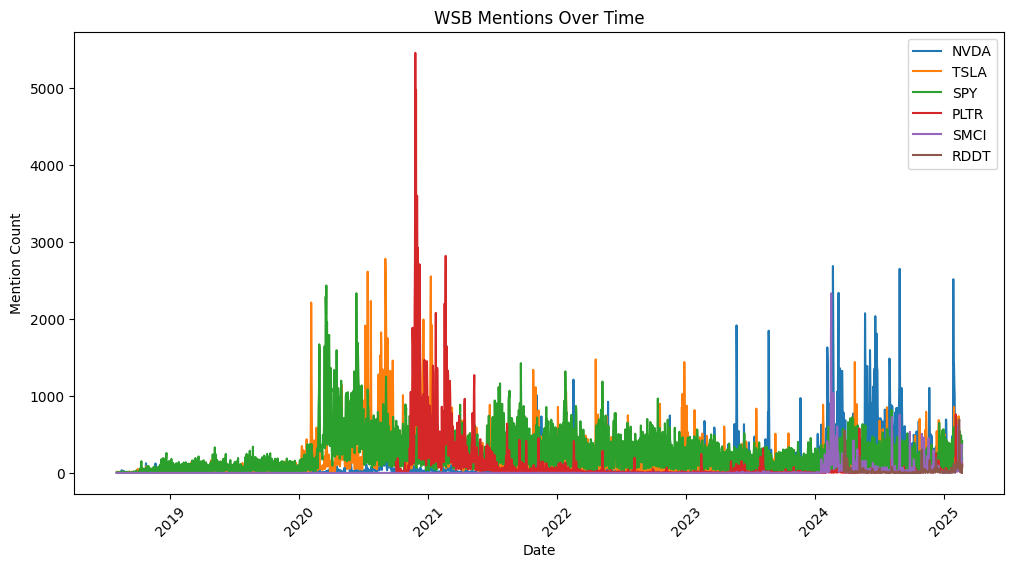


Conclusion: WSB discussion shows high volatility with dramatic spikes and valleys.
Different tickers peak during different periods, rejecting null hypothesis of consistent discussion.


In [24]:
# Plot mentions over time
ax = plot_mentions(ticker_data)
plt.show()

print("\nConclusion: WSB discussion shows high volatility with dramatic spikes and valleys.")
print("Different tickers peak during different periods, rejecting null hypothesis of consistent discussion.")

## Research Questions 2-4: Correlation Analysis

Testing correlations between:
- WSB mentions vs trading volume
- WSB mentions vs absolute price changes  
- WSB sentiment vs price direction

In [25]:
# Run all correlation analyses
results = run_all_correlations(ticker_data)

# Display results in a nice table
results_df = pd.DataFrame(results).T
print("\nCorrelation Results:")
print("=" * 60)
print(f"{'Ticker':<8} {'Vol_r':<8} {'Vol_p':<8} {'Abs_r':<8} {'Abs_p':<8} {'Sent_r':<8} {'Sent_p':<8}")
print("-" * 60)

for ticker in results:
    r = results[ticker]
    print(f"{ticker:<8} {r['mention_volume_r']:<8.3f} {r['mention_volume_p']:<8.3f} {r['mention_abs_price_r']:<8.3f} {r['mention_abs_price_p']:<8.3f} {r['sentiment_price_r']:<8.3f} {r['sentiment_price_p']:<8.3f}")

print(f"\nBonferroni threshold: {BONFERRONI_THRESHOLD:.4f}")


Correlation Results:
Ticker   Vol_r    Vol_p    Abs_r    Abs_p    Sent_r   Sent_p  
------------------------------------------------------------
NVDA     0.141    0.000    0.211    0.000    0.072    0.000   
TSLA     0.420    0.000    0.374    0.000    0.049    0.016   
SPY      0.472    0.000    0.440    0.000    0.014    0.502   
PLTR     0.411    0.000    0.342    0.000    0.032    0.196   
SMCI     0.708    0.000    0.385    0.000    0.074    0.000   
RDDT     0.713    0.000    0.461    0.000    0.061    0.267   

Bonferroni threshold: 0.0083


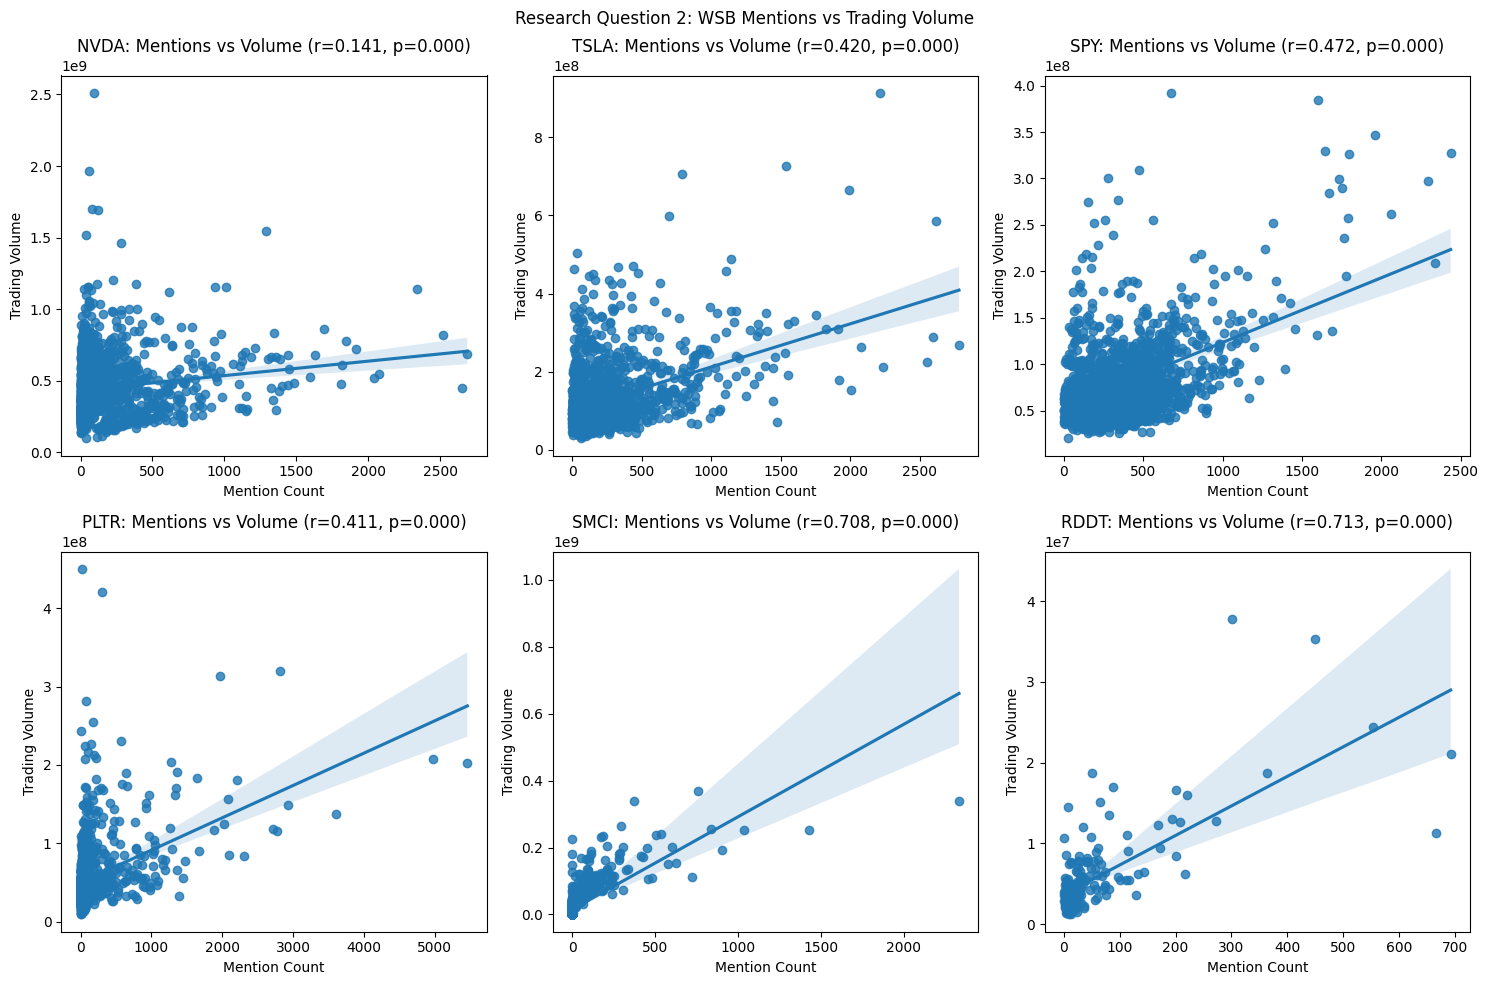


Conclusion Q2: All tickers show significant positive correlations between mentions and volume.
WSB discussion reliably coincides with elevated trading activity.


In [26]:
# Research Question 2: Mentions vs Volume
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ticker in enumerate(STOCK_TICKERS):
    if ticker in ticker_data:
        analyze_mention_volume_correlation(ticker_data[ticker], axes[i], ticker)

plt.suptitle('Research Question 2: WSB Mentions vs Trading Volume')
plt.tight_layout()
plt.show()

print("\nConclusion Q2: All tickers show significant positive correlations between mentions and volume.")
print("WSB discussion reliably coincides with elevated trading activity.")

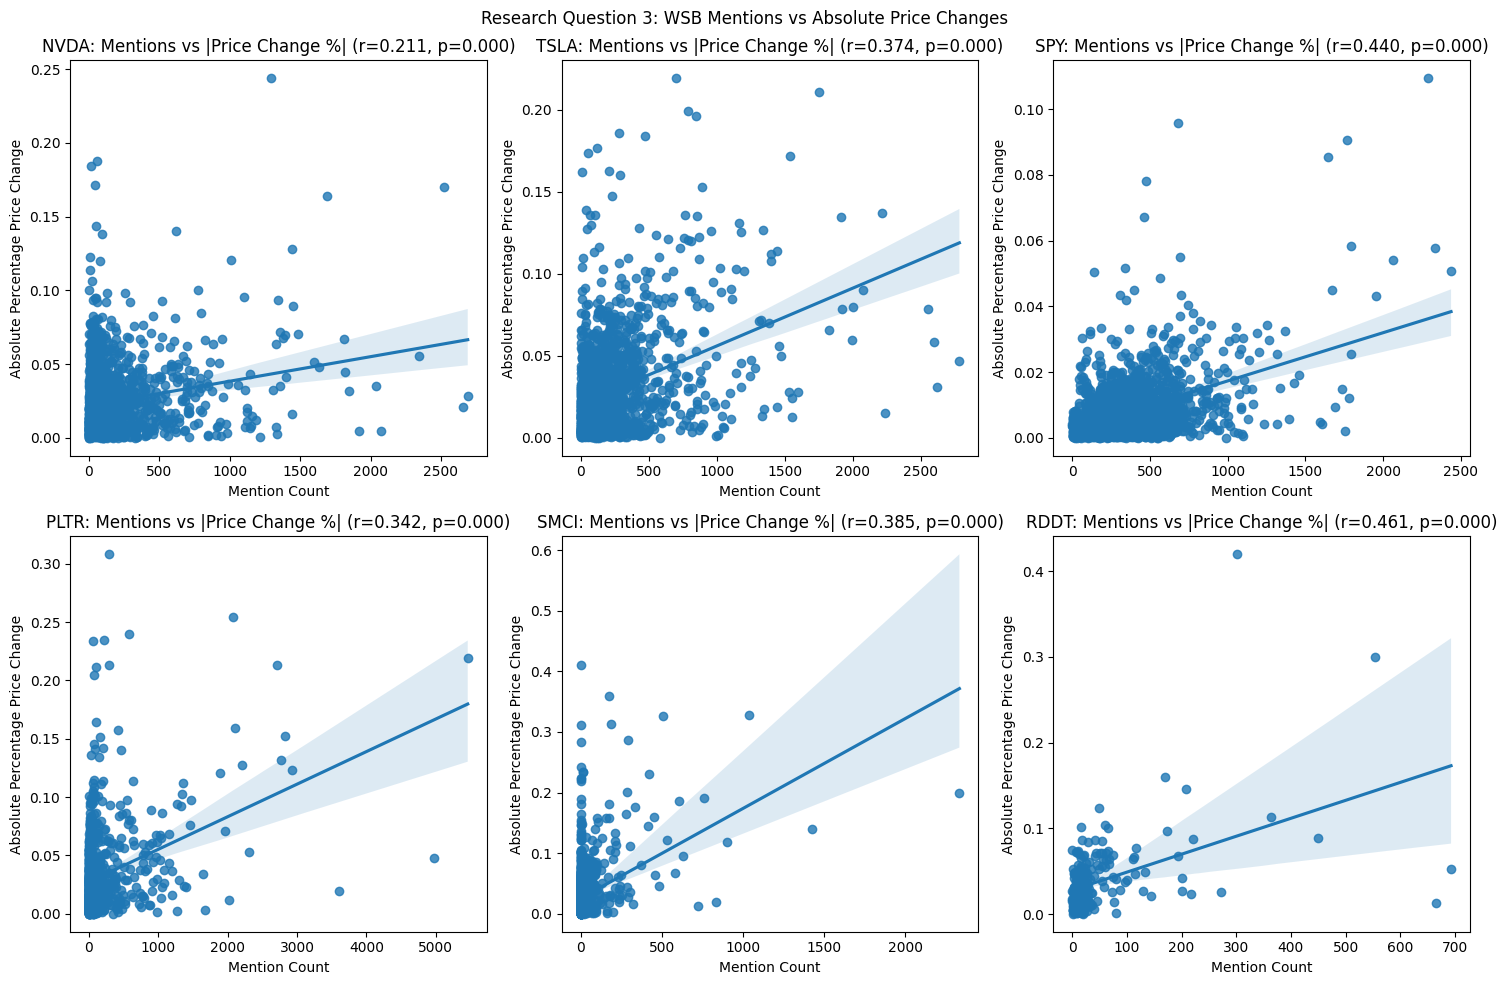


Conclusion Q3: All tickers show positive correlations between mentions and price volatility.
WSB attention consistently accompanies larger price movements regardless of direction.


In [27]:
# Research Question 3: Mentions vs Absolute Price Changes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ticker in enumerate(STOCK_TICKERS):
    if ticker in ticker_data:
        analyze_mention_abs_price_correlation(ticker_data[ticker], axes[i], ticker)

plt.suptitle('Research Question 3: WSB Mentions vs Absolute Price Changes')
plt.tight_layout()
plt.show()

print("\nConclusion Q3: All tickers show positive correlations between mentions and price volatility.")
print("WSB attention consistently accompanies larger price movements regardless of direction.")

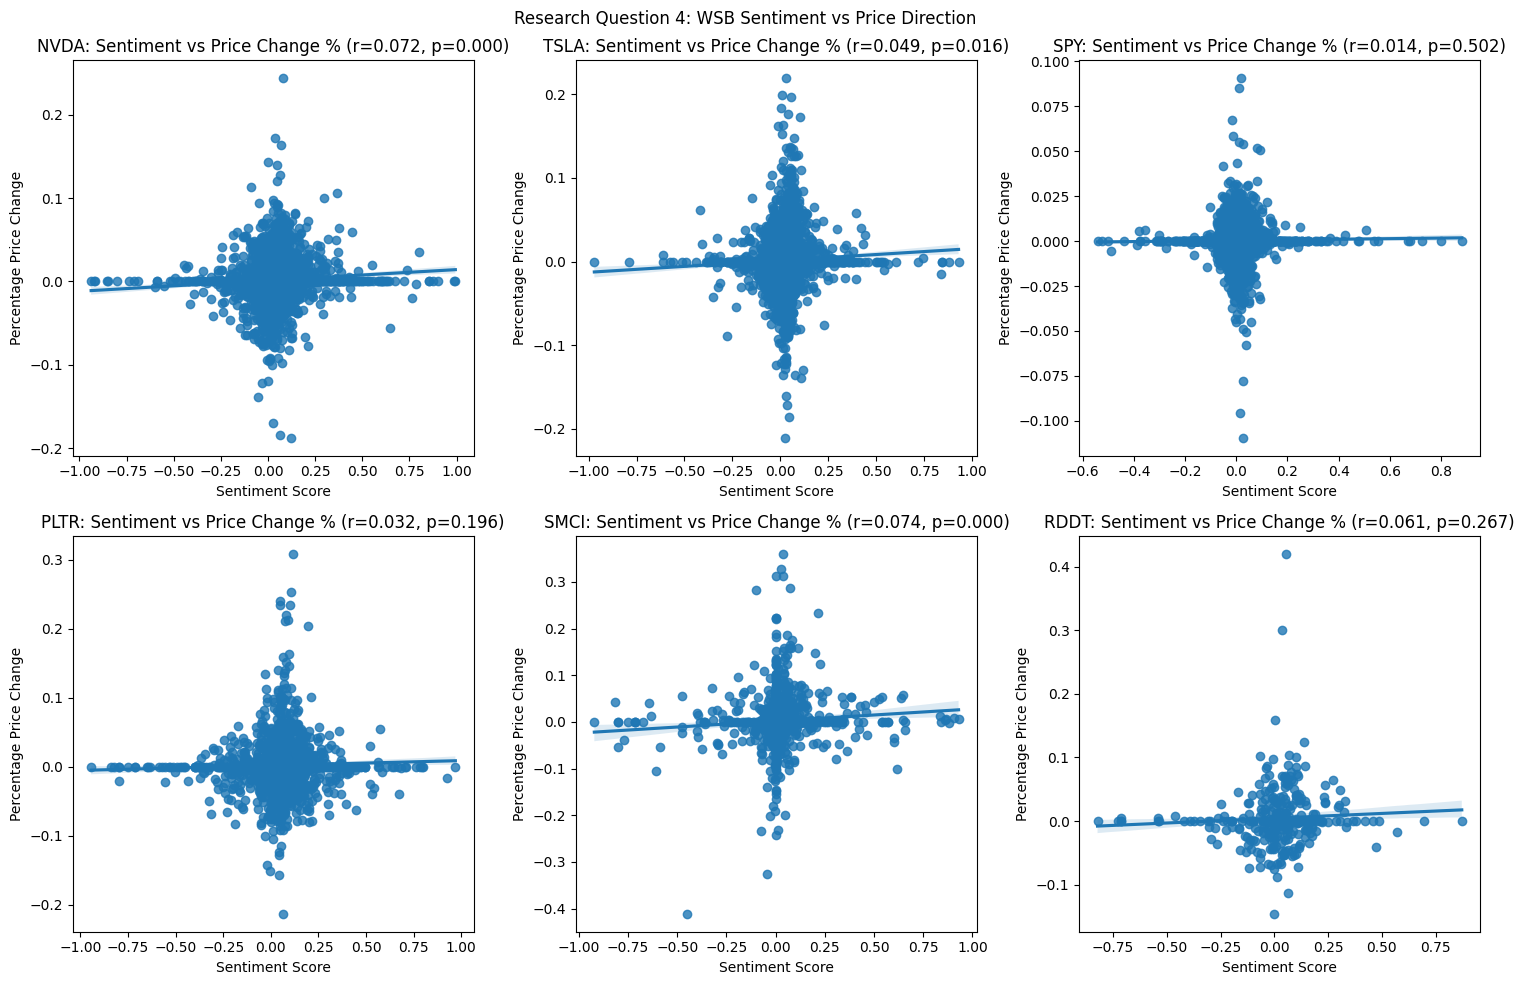


Conclusion Q4: Sentiment shows minimal predictive value for price direction.
Even significant correlations explain <1.5% of price variance.


In [28]:
# Research Question 4: Sentiment vs Price Direction
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ticker in enumerate(STOCK_TICKERS):
    if ticker in ticker_data:
        analyze_sentiment_price_correlation(ticker_data[ticker], axes[i], ticker)

plt.suptitle('Research Question 4: WSB Sentiment vs Price Direction')
plt.tight_layout()
plt.show()

print("\nConclusion Q4: Sentiment shows minimal predictive value for price direction.")
print("Even significant correlations explain <1.5% of price variance.")

## Research Question 5: Lead/Lag Analysis

Does WSB sentiment lead or lag stock price movements?

In [29]:
# Create shifted data for lead/lag analysis
ticker_data_0 = ticker_data.copy()
for ticker, df in ticker_data.items():
    ticker_data_0[ticker] = df.copy().dropna()

# Data relating past sentiment data to current stock prices
ticker_data_lead_1 = create_shifted_data(ticker_data, 1)
ticker_data_lead_2 = create_shifted_data(ticker_data, 2)
ticker_data_lead_3 = create_shifted_data(ticker_data, 3)

# Data relating future sentiment data to current stock prices
ticker_data_lag_1 = create_shifted_data(ticker_data, -1)
ticker_data_lag_2 = create_shifted_data(ticker_data, -2)
ticker_data_lag_3 = create_shifted_data(ticker_data, -3)

lead_lag_data = {
    'lead_3': ticker_data_lead_3,
    'lead_2': ticker_data_lead_2,
    'lead_1': ticker_data_lead_1,
    '0': ticker_data_0,
    'lag_1': ticker_data_lag_1,
    'lag_2': ticker_data_lag_2,
    'lag_3': ticker_data_lag_3
}

print("Lead/lag data prepared!")

Lead/lag data prepared!


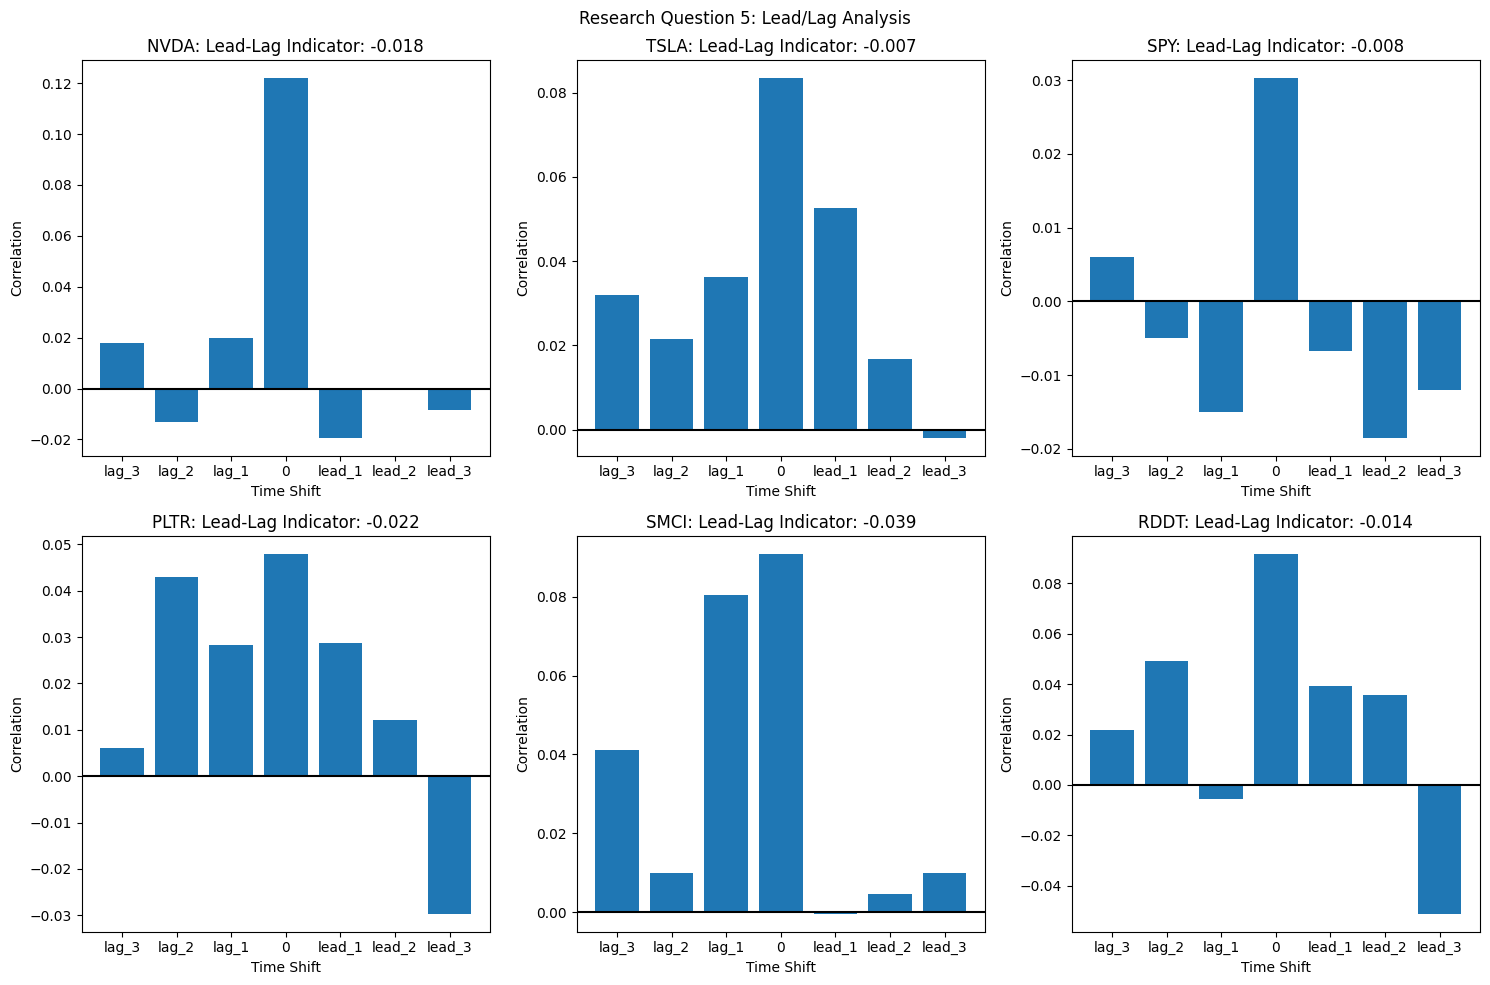


Lead/Lag Indicators (negative = sentiment lags prices):
NVDA: -0.018
TSLA: -0.007
SPY: -0.008
PLTR: -0.022
SMCI: -0.039
RDDT: -0.014

Conclusion Q5: WSB sentiment primarily follows rather than predicts price movements.
Five of six tickers show negative indicators, confirming reactive behavior.


In [30]:
# Lead-Lag Analysis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

lead_lag_results = {}
for i, ticker in enumerate(STOCK_TICKERS):
    if ticker in ticker_data:
        indicator, zero_corr = analyze_lead_lag_correlations(ticker, axes[i], lead_lag_data)
        lead_lag_results[ticker] = {'indicator': indicator, 'zero_correlation': zero_corr}

plt.suptitle('Research Question 5: Lead/Lag Analysis')
plt.tight_layout()
plt.show()

print("\nLead/Lag Indicators (negative = sentiment lags prices):")
for ticker, result in lead_lag_results.items():
    print(f"{ticker}: {result['indicator']:.3f}")

print("\nConclusion Q5: WSB sentiment primarily follows rather than predicts price movements.")
print("Five of six tickers show negative indicators, confirming reactive behavior.")

## Summary of Results

### Key Findings:
1. **Discussion Consistency**: WSB discussion is highly volatile with dramatic spikes
2. **Volume Correlation**: Strong positive correlations (r=0.14-0.71) between mentions and trading volume
3. **Volatility Prediction**: Moderate correlations (r=0.21-0.46) between mentions and price volatility
4. **Sentiment Prediction**: Minimal predictive value (râ‰¤0.12) for price direction
5. **Lead/Lag**: WSB primarily reacts to rather than predicts market movements

### Statistical Framework:
- Used Bonferroni correction for multiple testing (Î± = 0.0083)
- All volume and volatility correlations significant at p < 0.001
- Sentiment correlations weak despite some statistical significance